## Camvid segmentation

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai import *
from fastai.vision import *

In [ ]:
path = Path('data/camvid')

In [ ]:
path.ls()

[PosixPath('data/camvid/valid.txt'),
 PosixPath('data/camvid/labels'),
 PosixPath('data/camvid/codes.txt'),
 PosixPath('data/camvid/images')]

In [ ]:
path_lbl = path/'labels'
path_img = path/'images'

In [ ]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('data/camvid/images/0016E5_08065.png'),
 PosixPath('data/camvid/images/0006R0_f01500.png'),
 PosixPath('data/camvid/images/0016E5_06510.png'),
 PosixPath('data/camvid/images/0016E5_01440.png'),
 PosixPath('data/camvid/images/0001TP_009870.png')]

In [ ]:
path_lbl.ls()[:5]

[PosixPath('data/camvid/labels/0006R0_f01770_P.png'),
 PosixPath('data/camvid/labels/0006R0_f01290_P.png'),
 PosixPath('data/camvid/labels/Seq05VD_f02940_P.png'),
 PosixPath('data/camvid/labels/0001TP_007470_P.png'),
 PosixPath('data/camvid/labels/0016E5_05040_P.png')]

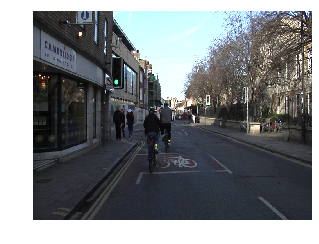

In [ ]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [ ]:
codes = np.loadtxt(path/'codes.txt', dtype=str)
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car',
       'CartLuggagePram', 'Child', 'Column_Pole', 'Fence', 'LaneMkgsDriv',
       'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving',
       'ParkingBlock', 'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk',
       'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel',
       'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [ ]:
def get_y_fn(fn): return path_lbl/f'{fn.name[:-4]}_P.png'

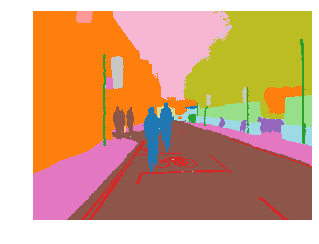

In [ ]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), cmap='tab20', alpha=1)

In [ ]:
mask.data

tensor([[[ 4,  4,  4,  ..., 26, 26, 26],
         [ 4,  4,  4,  ..., 26, 26, 26],
         [ 4,  4,  4,  ..., 26, 26, 26],
         ...,
         [19, 19, 19,  ..., 17, 17, 17],
         [19, 19, 19,  ..., 17, 17, 17],
         [19, 19, 19,  ..., 17, 17, 17]]])

- valid set?
  - path
  - fnames
  - idxs
  - min idx
  - rand pct
- type of data
- source of labels

In [ ]:
valid_fns = np.loadtxt(path/'valid.txt', dtype=str)
valid_fns[:5]

array(['0016E5_07959.png', '0016E5_07961.png', '0016E5_07963.png',
       '0016E5_07965.png', '0016E5_07967.png'], dtype='<U16')

In [ ]:
valid_fns = [path_img/o for o in valid_fns]
train_fns = list(set(fnames)-set(valid_fns))

In [ ]:
y_train_fns = [get_y_fn(o) for o in train_fns]
y_valid_fns = [get_y_fn(o) for o in valid_fns]
len(train_fns),len(valid_fns),len(y_train_fns),len(y_valid_fns)

(600, 101, 600, 101)

In [ ]:
size=128
bs=32

In [ ]:
train_ds = SegmentationDataset(train_fns, y_train_fns)
valid_ds = SegmentationDataset(valid_fns, y_valid_fns)

In [ ]:
train_tfms,valid_tfms = get_transforms()

In [ ]:
train_tds = DatasetTfm(train_ds, train_tfms, size=size, tfm_y=True)
valid_tds = DatasetTfm(valid_ds, valid_tfms, size=size, tfm_y=True)

In [ ]:
data = DataBunch.create(train_tds, valid_tds, bs=bs)

In [ ]:
x,y = zip(*[train_tds[i] for i in range(9)])

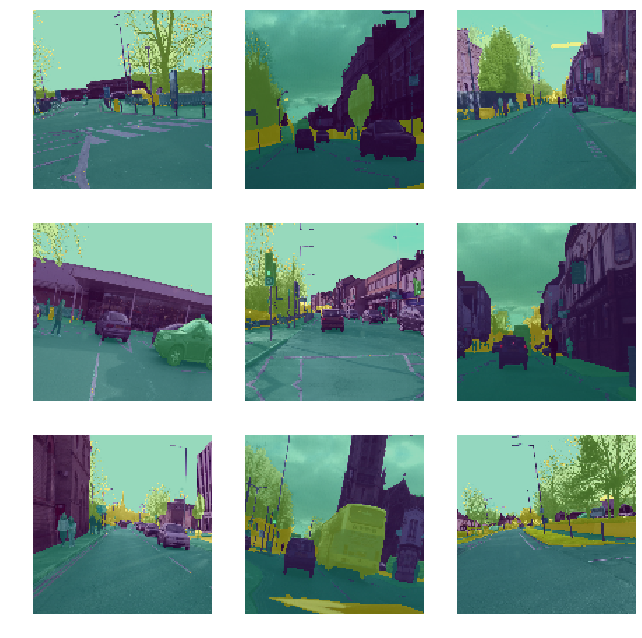

In [ ]:
show_xy_images(x, y, rows=3)

In [ ]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

In [ ]:
def accuracy_no_void(input, target, void_code):
    target = target.squeeze()
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [ ]:
metrics=partial(accuracy_no_void, void_code=void_code)
lr = 1e-3

In [ ]:
body = create_body(models.resnet34(True), -2)
model = models.unet.DynamicUnet(body, n_classes=len(codes)).cuda()
learn = Learner(data, model, metrics=metrics, loss_func=CrossEntropyFlat())
learn.split([model[0][6], model[1]])
learn.freeze()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


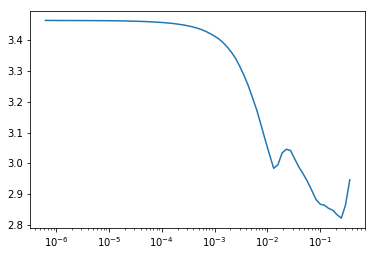

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr = 1e-3

In [ ]:
learn.fit_one_cycle(6, slice(lr))

Total time: 00:44
epoch  train_loss  valid_loss  accuracy_no_void
1      3.385426    3.422903    0.319053          (00:07)
2      3.101482    2.323664    0.610851          (00:07)
3      2.508759    1.520119    0.630616          (00:07)
4      2.005524    1.246970    0.637943          (00:07)
5      1.676015    1.182036    0.636123          (00:07)
6      1.467879    1.124384    0.638336          (00:07)



In [ ]:
learn.unfreezefreeze()

In [ ]:
learn.fit_one_cycle(6, slice(lr/100,lr))

Total time: 00:44
epoch  train_loss  valid_loss  accuracy_no_void
1      1.056424    1.094650    0.715846          (00:07)
2      0.995913    0.864256    0.784381          (00:07)
3      0.921122    0.767860    0.796627          (00:07)
4      0.862722    0.757764    0.823520          (00:07)
5      0.819419    0.715740    0.829715          (00:07)
6      0.785783    0.683773    0.837345          (00:07)

